In [2]:
import json, os, sys, cv2
sys.path.append('..')

from modules.process import *
from modules.display import *
from modules.curvature import compute_list_divided_curvature_radii
from modules.helper import *

# データ読み込み

In [ ]:
conf = load_yaml('conf.yaml')
instance0 = MyImages()
instance0.load_image(conf['path'])

# 画像切り取り

In [5]:
""" Execute cropping """

instance = MyImages()
xl, xr, yl, yr = conf['crop']
if conf['negative_image']:
    tmp = instance0.gray_images[:, yl:yr, xl:xr]
    instance.gray_images = [np.max(img) - img for img in tmp]
else:
    instance.gray_images = instance0.gray_images[:, yl:yr, xl:xr]
instance.dust_mask = np.zeros(instance.gray_images[0].shape)

display_stats(instance.gray_images[0])
print(len(instance.gray_images))

{'min': 704, 'max': 1404, 'mean': 1036.2015612648222, 'std': 93.24527552980712, 'median': 1031.0}
189


# 液滴の円近似（otsu binarization）

### Check algorithm here: a mask and contours for a certain image

otsu thresh=1073.0
large contour indices=[]


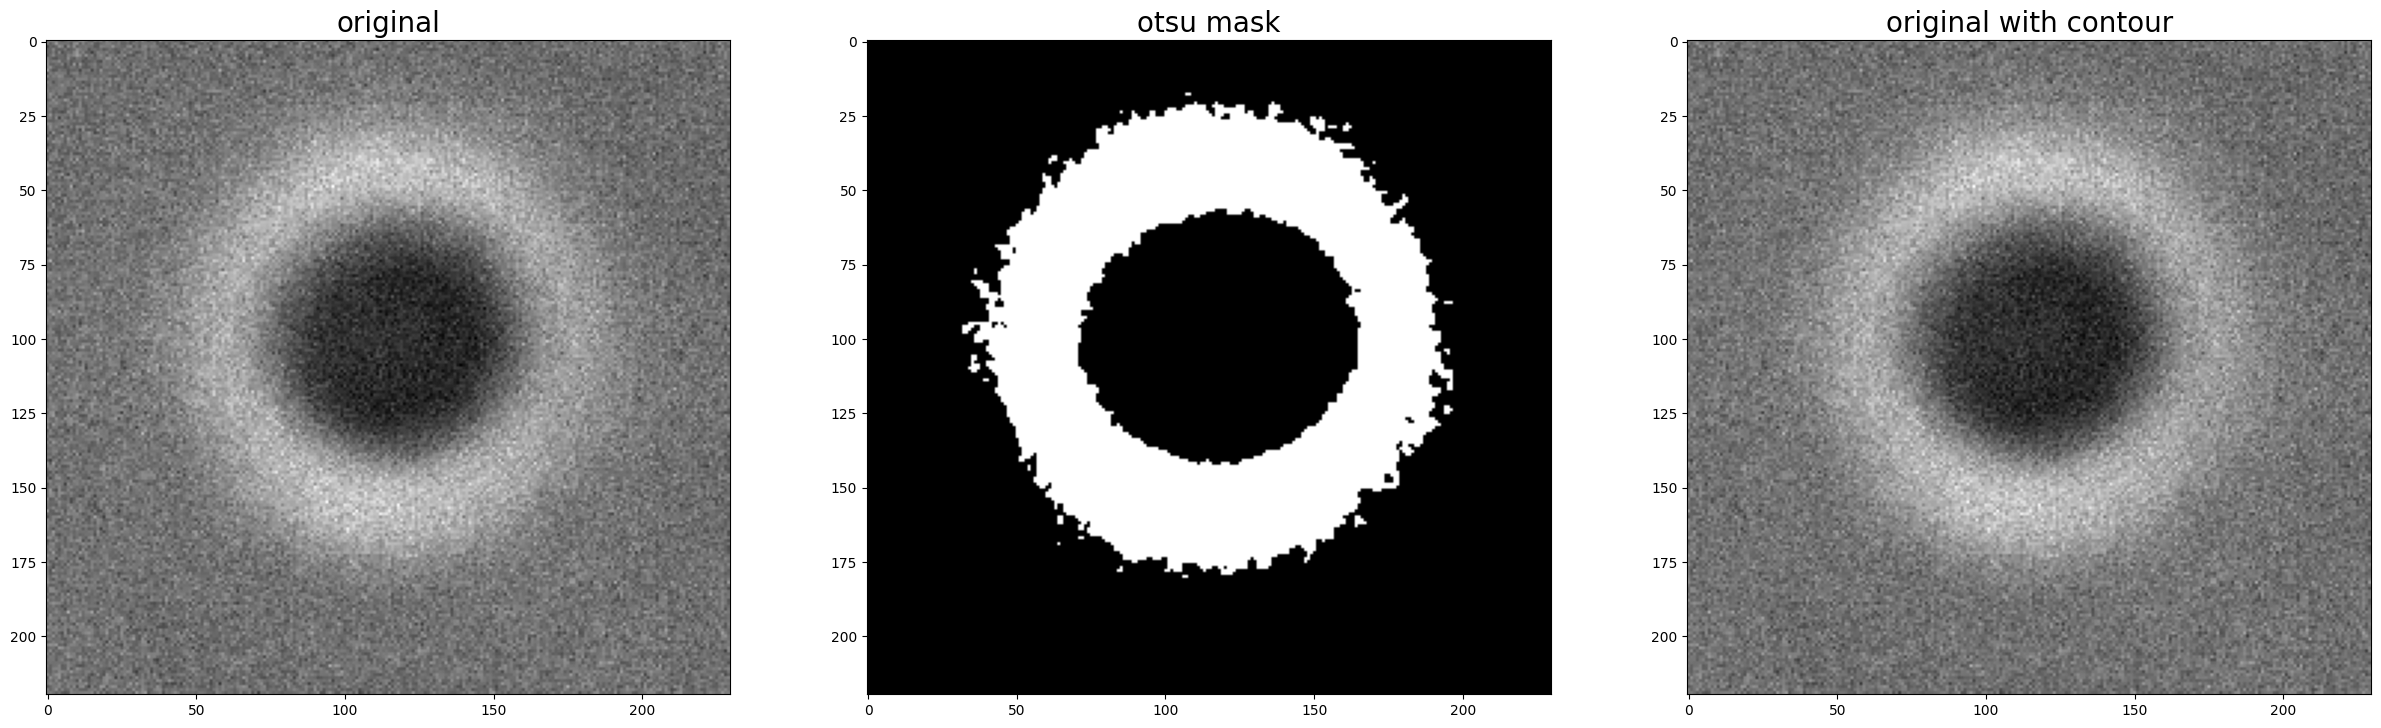

In [6]:
index = 0

src = instance.gray_images[index].copy()
blurred = cv2.GaussianBlur(src, (5, 5), sigmaX=0, sigmaY=0)
thresh, mask = cv2.threshold(blurred, 0, 2**16, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
contours, _ = cv2.findContours(mask[index].astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
large_contour_indices = [i for i, c in enumerate(contours) if len(c) > 50]

canvas = src.copy()
for i in large_contour_indices:
    cv2.drawContours(canvas, contours, i, i, i + 1)

print(f'otsu thresh={thresh}')
print(f'large contour indices={large_contour_indices}')
display_images([src, mask, canvas], ['original', 'otsu mask', 'original with contour'])

### masks

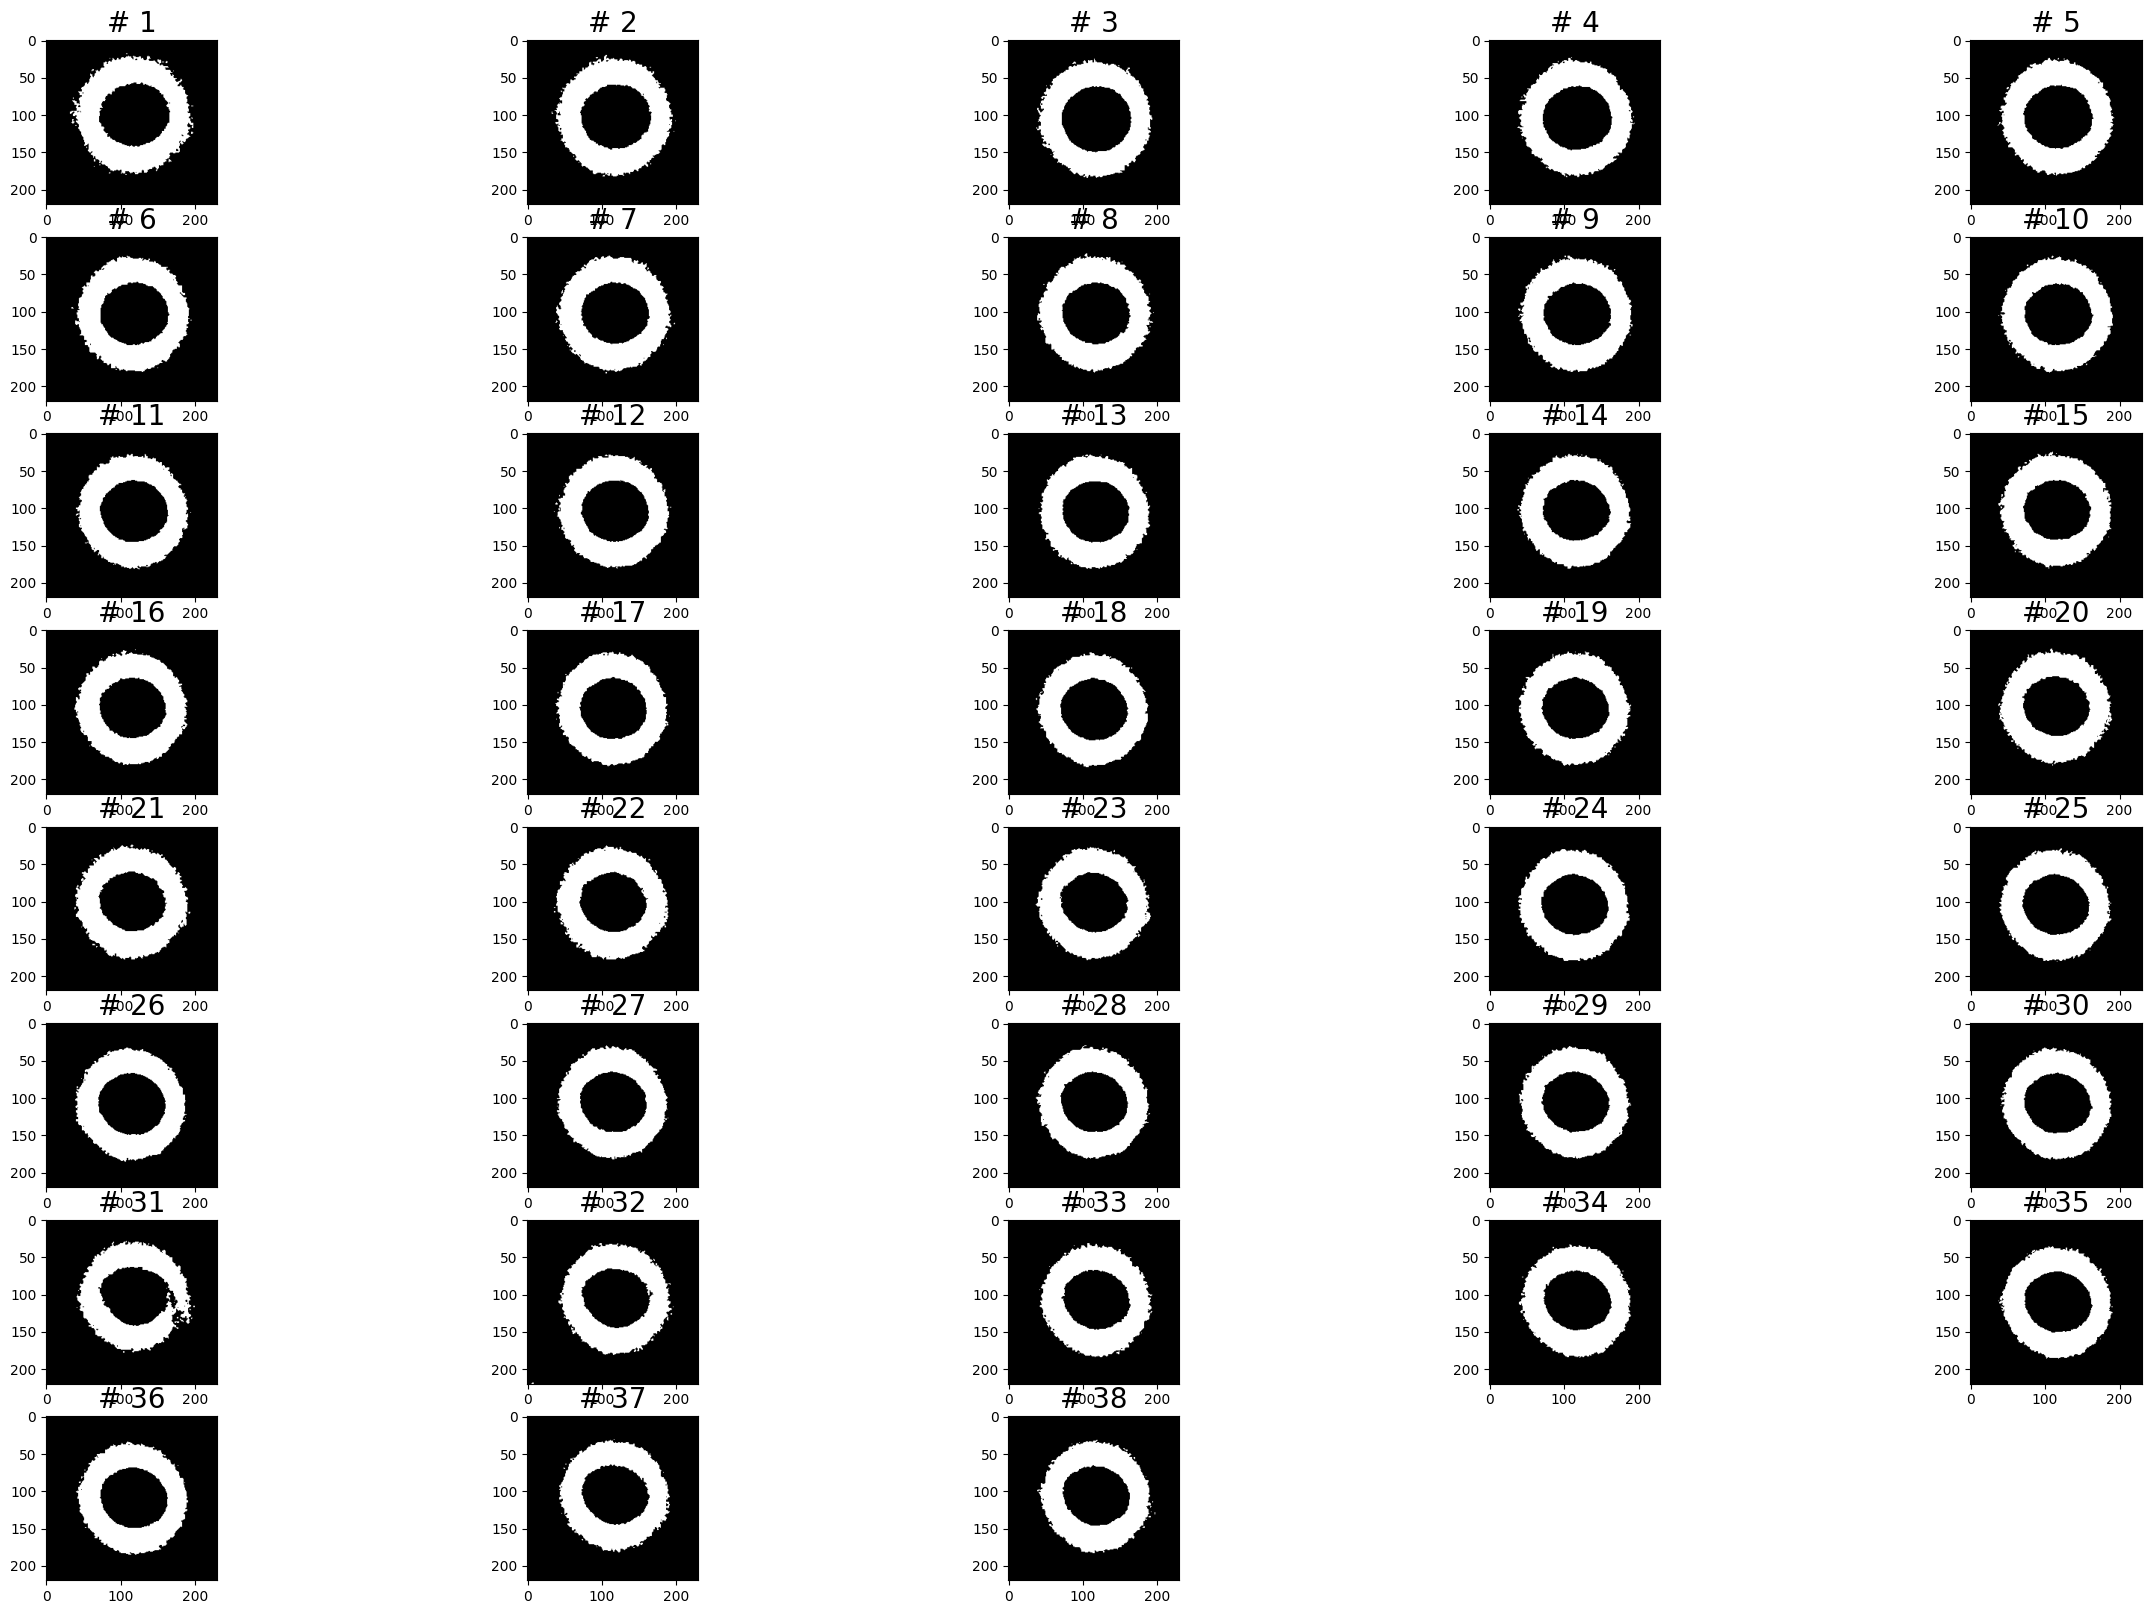

In [23]:
otsu_masks = []
for src in instance.gray_images:
    blurred = cv2.GaussianBlur(src, (5, 5), sigmaX=0, sigmaY=0)
    thresh, dst = cv2.threshold(blurred, 0, 2**16, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    dst = dst / np.max(dst)
    otsu_masks.append(dst.astype('uint8'))
display_images(otsu_masks[::5], w=5)

## Fitting 1: with my fitting function

In [25]:
list_arr_circle = []
for mask in otsu_masks:
    arr_circle, arr_points = fit_points_to_circle_iteration(mask, w_out=conf['fitting_extra_width_outside'], itr=conf['fitting_iteraion_number'])
    list_arr_circle.append(arr_circle)

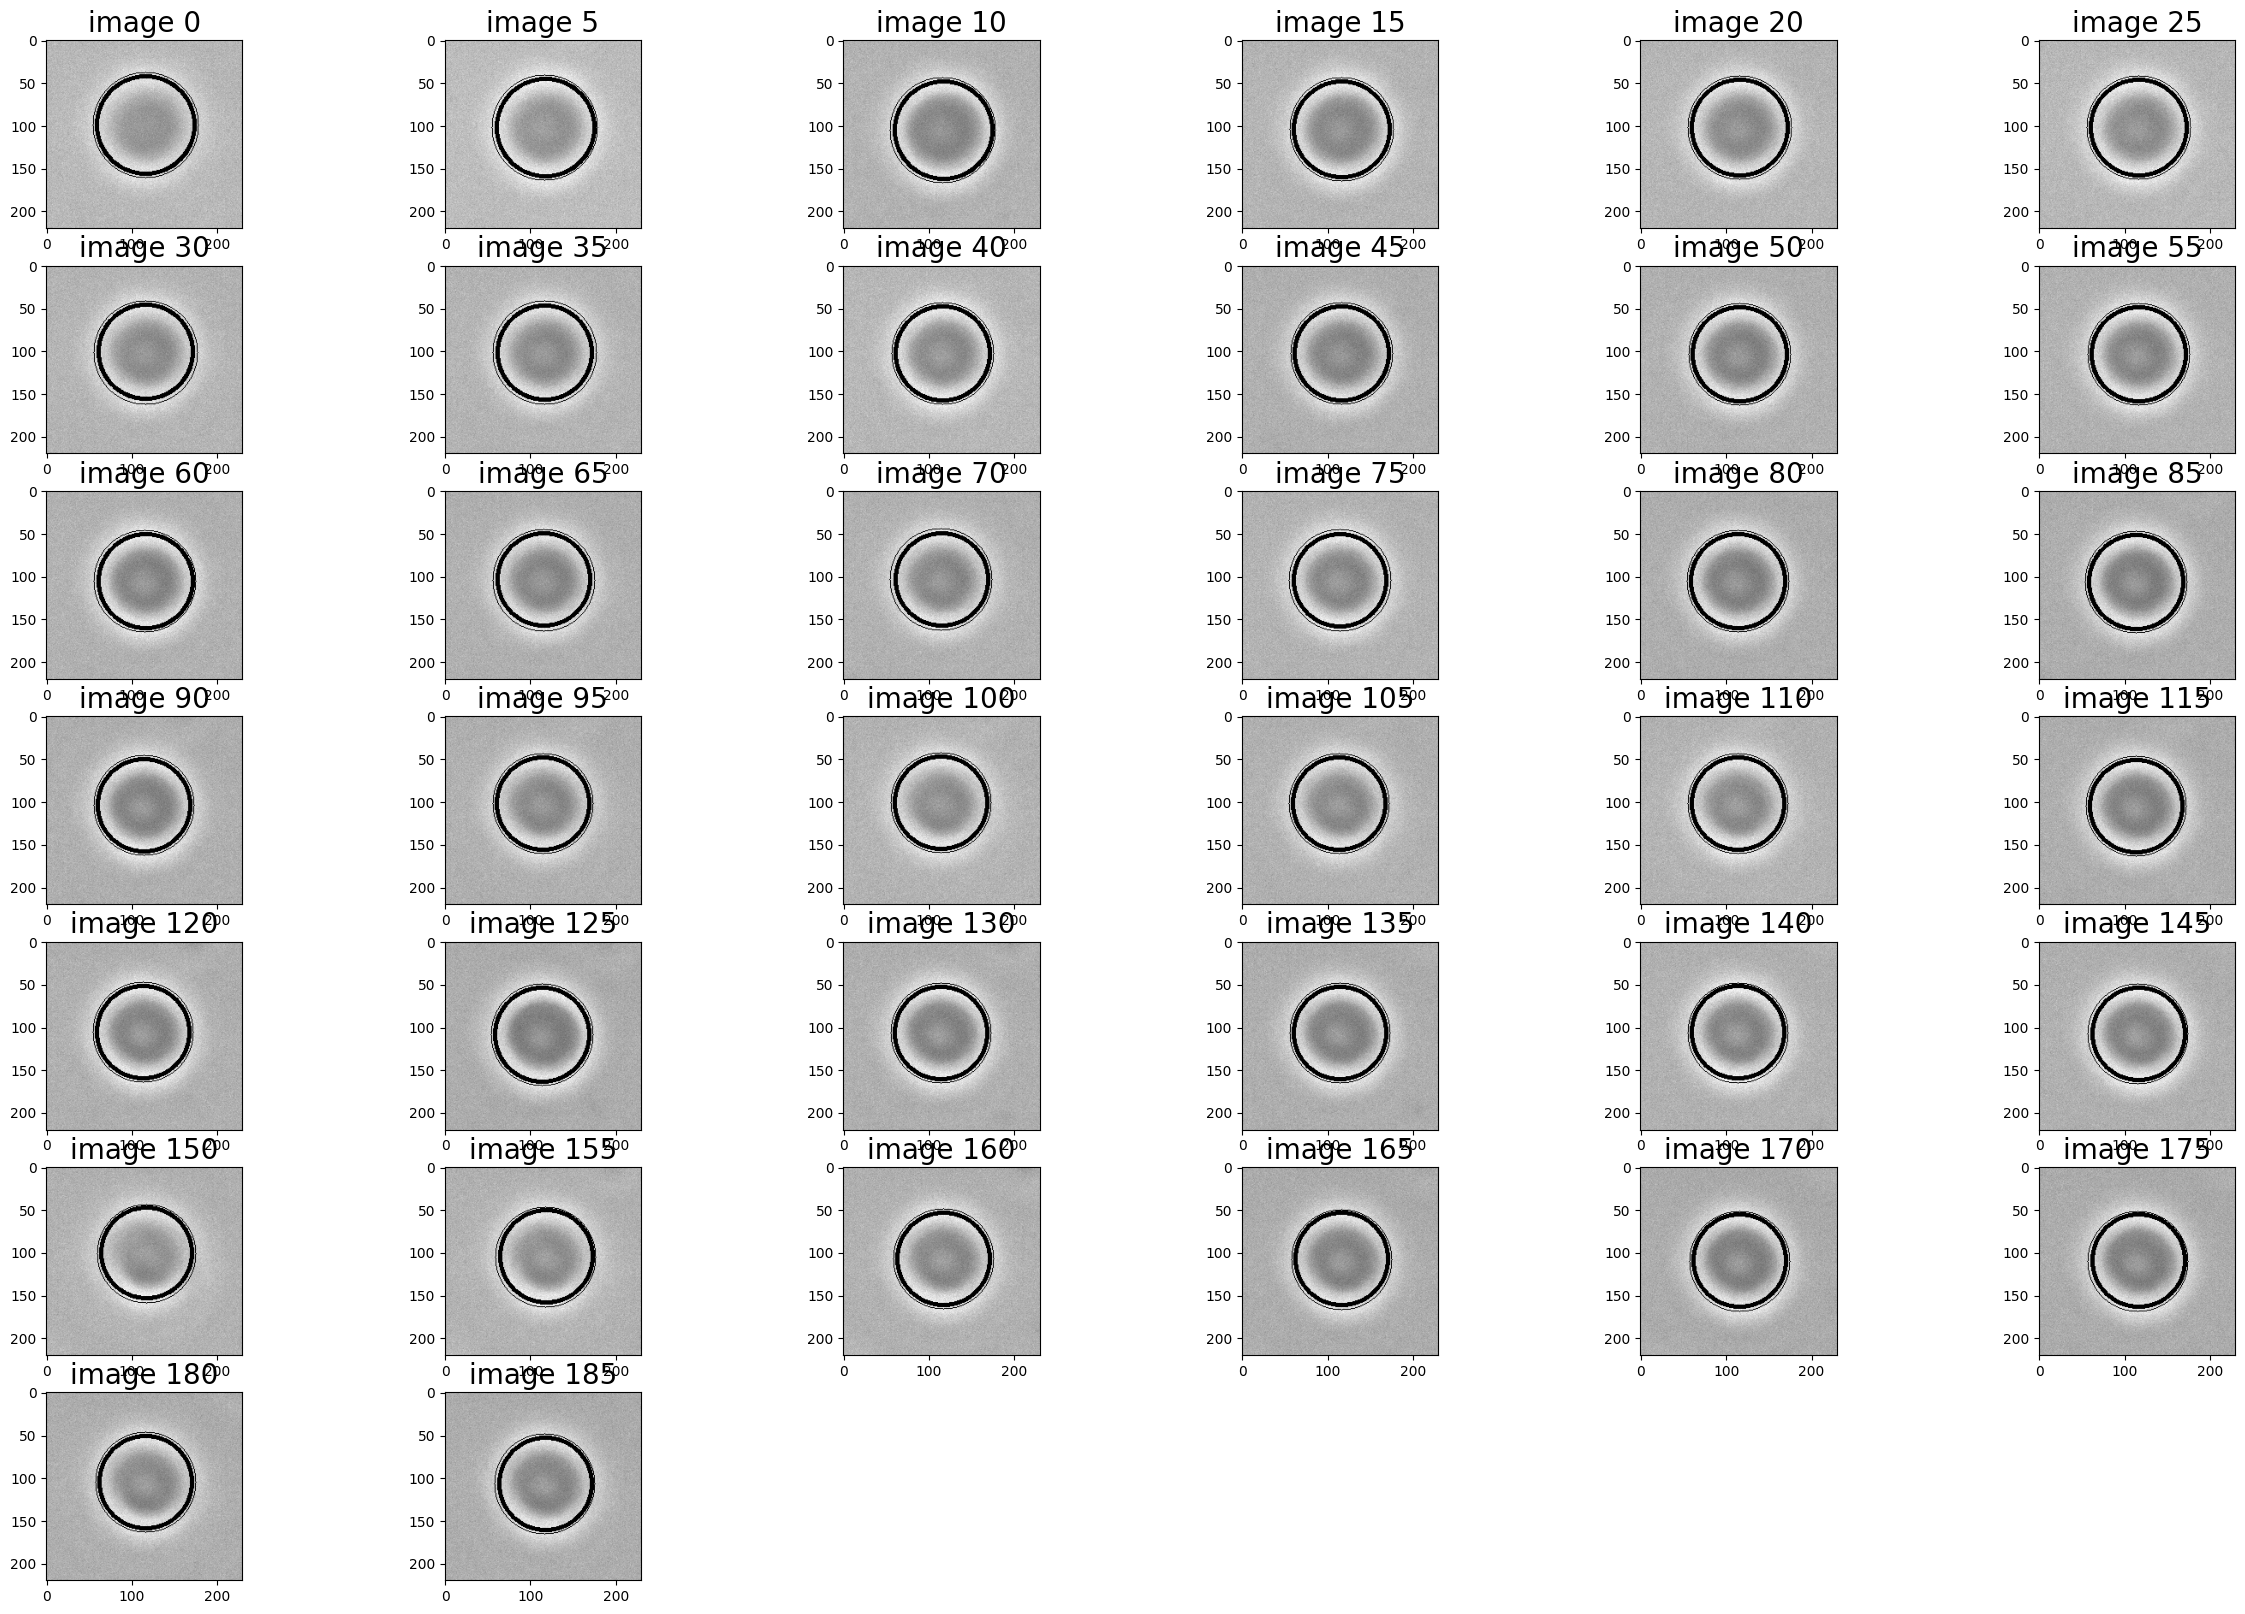

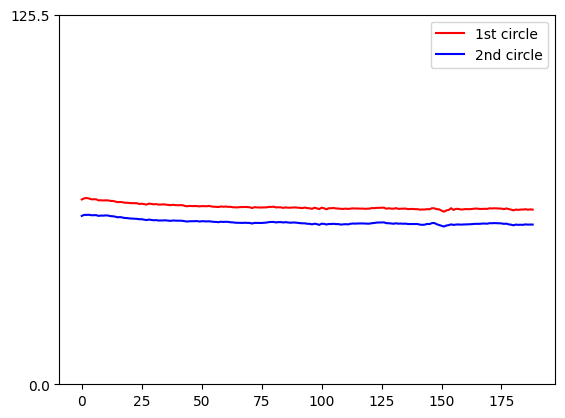

In [ ]:
display_original_images_with_circles(instance, list_arr_circle, range(0, len(instance.gray_images), 5))
display_droplet_radii(list_arr_circle)

In [ ]:
save_arr0 = [0] + [arr_circle[0][2] for arr_circle in list_arr_circle]
save_arr1 = [1] + [arr_circle[1][2] for arr_circle in list_arr_circle]
save_as_csv([conf['fps'], conf['scale']], f'../data/crop{conf['crop_id']}_otsu_radii_{filename}.csv')
save_as_csv(save_arr0, f'../data/crop{conf['crop_id']}_otsu_radii_{filename}.csv')
save_as_csv(save_arr1, f'../data/crop{conf['crop_id']}_otsu_radii_{filename}.csv')

## Fitting 2: with largest contour

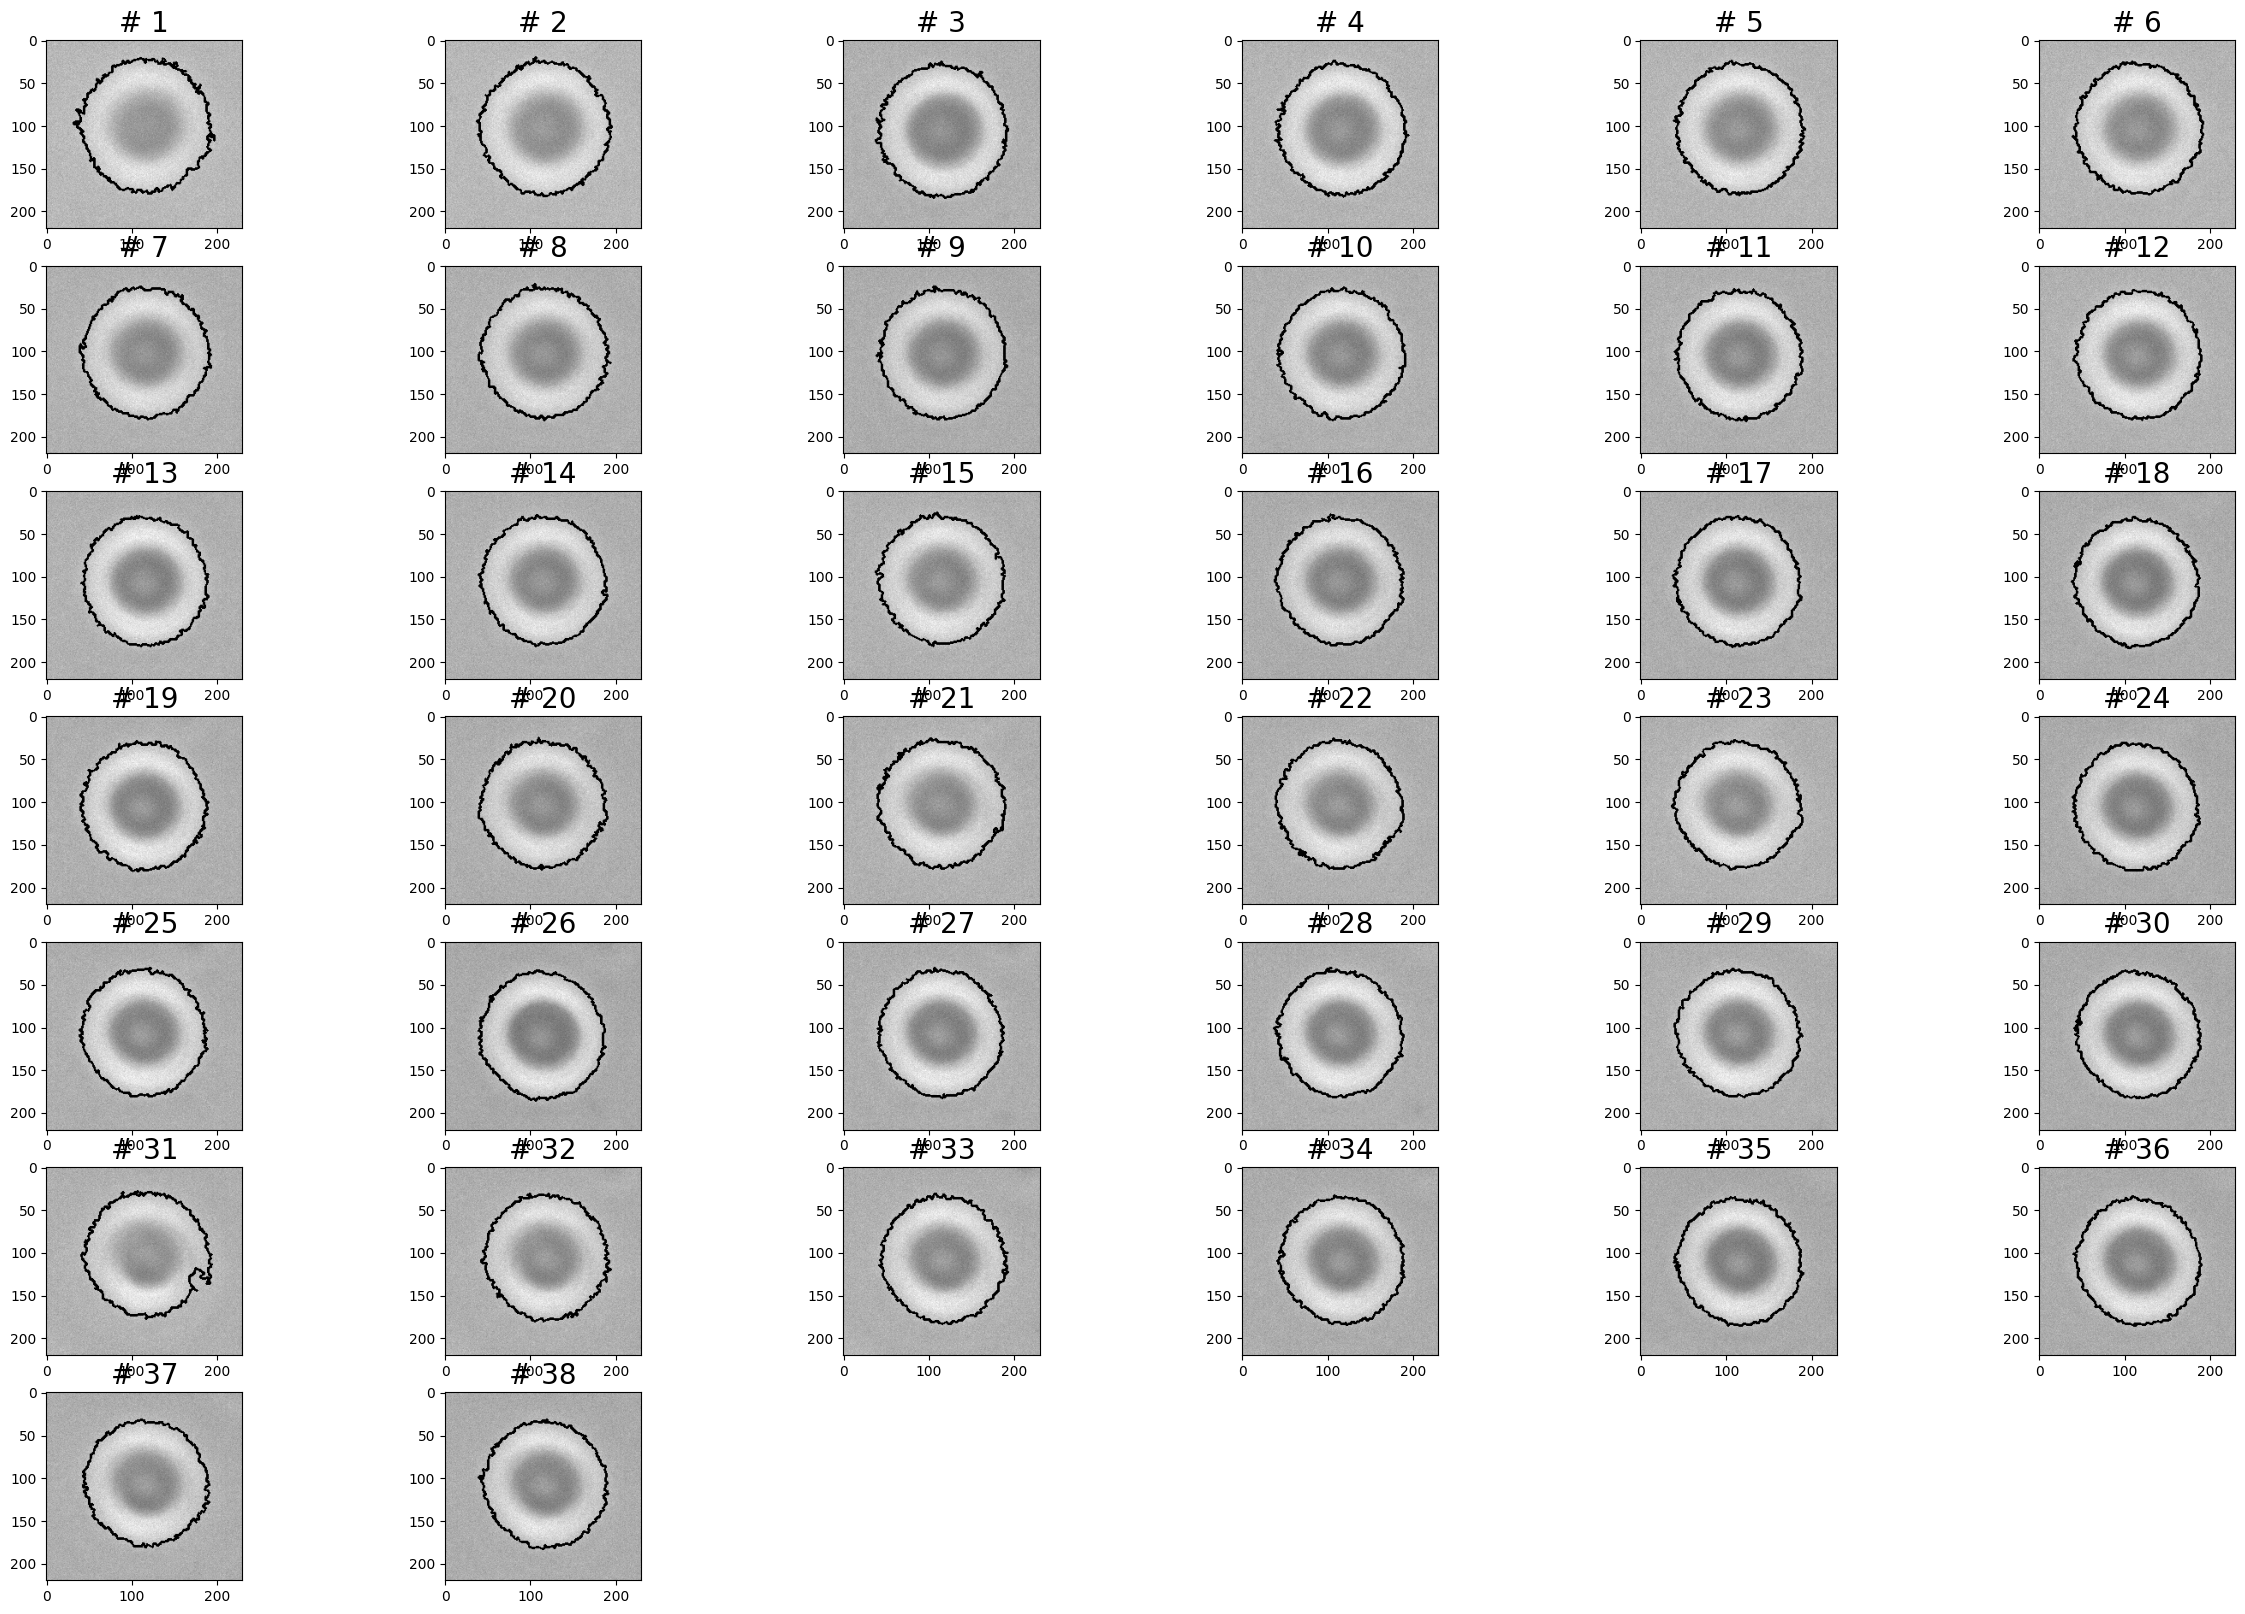

In [12]:
list_contour = []
list_canvas = []
for index in range(len(otsu_masks)):
    contours, _ = cv2.findContours(otsu_masks[index], cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
    contour_index = np.argmax(np.array([len(c) for c in contours]))
    canvas = instance.gray_images[index].copy()
    cv2.drawContours(canvas, contours, contour_index, 0, 2)
    list_contour.append(contours[contour_index])
    list_canvas.append(canvas)

display_images(list_canvas[::5], w=6)

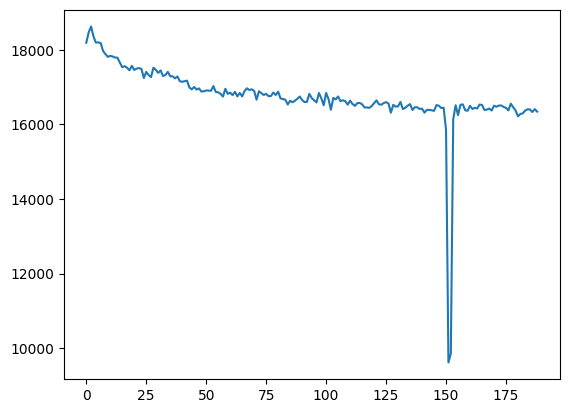

In [ ]:
def display_contour_areas(list_contour):
    n = len(list_contour)
    areas = [cv2.contourArea(contour) for contour in list_contour]
    plt.plot(range(n), areas)

import csv
def save_as_csv(arr, path):
    with open(path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(arr)

display_contour_areas(list_contour)

In [ ]:
save_as_csv([conf['fps'], conf['scale']], f'../data/crop{conf['crop_id']}_otsu_contour_area_{filename}.csv')
save_as_csv(list_contour, f'../data/crop{conf['crop_id']}_otsu_contour_area_{filename}.csv')